In [1]:
# pip install -q lightning-tutorial

In [2]:
%load_ext nb_black

import lightning_tutorial as lt

<IPython.core.display.Javascript object>

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'cell_type_idx'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'color_palette'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


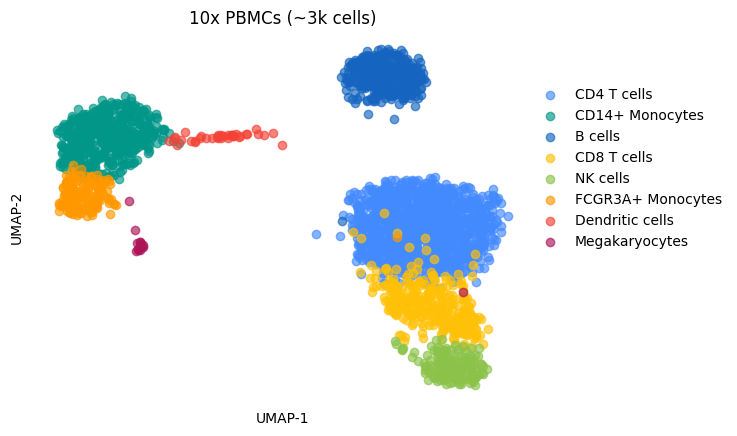

<IPython.core.display.Javascript object>

In [3]:
adata = lt.data.pbmc3k()

### Create a torch `Dataset` from `adata`

Start by creating a dataset with only the `X` component:

In [4]:
from torch_adata import AnnDataset

dataset = AnnDataset(adata)
print("X shape: {}".format(dataset.X.shape))
print("dataset length: {}".format(dataset.__len__()))

X shape: torch.Size([2638, 1838])
dataset length: 2638


<IPython.core.display.Javascript object>

In [5]:
import numpy as np

dummy_idx = np.random.choice(range(dataset.__len__()), 5)
dataset.__getitem__(dummy_idx)

tensor([[ 3.8880, -0.2636, -0.0491,  ..., -0.0806, -0.1675, -0.5003],
        [-0.2018, -0.2457, -0.0458,  ..., -0.0419, -0.1566,  2.1370],
        [-0.3037,  2.8413, -0.0542,  ..., -0.1503, -0.1939, -0.5143],
        [-0.2697, -0.2445, -0.0490,  ..., -0.0514, -0.1364, -0.4787],
        [-0.2722, -0.2532, -0.0497,  ..., -0.0672, -0.1467, -0.4853]])

<IPython.core.display.Javascript object>

Now let's create a dataset where we use some target labels (i.e., **`y`** in the traditional sense of `X ~ y`

In [6]:
dataset = AnnDataset(adata, obs_key="louvain")
print("X shape: {} | y shape: {}".format(dataset.X.shape, dataset.y.shape))
print("dataset length: {}".format(dataset.__len__()))

X shape: torch.Size([2638, 1838]) | y shape: torch.Size([2638, 8])
dataset length: 2638


<IPython.core.display.Javascript object>

Upon inspection of `dataset.y`, we see that the labels have been one-hot encoded:

In [7]:
dataset.y

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

<IPython.core.display.Javascript object>

### Split into `train` / `val`, then shove into a `DataLoader`

In [8]:
from torch.utils.data import random_split

<IPython.core.display.Javascript object>

In [9]:
n_cells = dataset.__len__()
n_train = n_cells - int(n_cells * 0.8)
n_val = n_cells - n_train
print("Train (# cells): {} | Val (# cells): {}".format(n_train, n_val))
train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

Train (# cells): 528 | Val (# cells): 2110


<IPython.core.display.Javascript object>

In [10]:
from torch.utils.data import DataLoader
import os

train_batch_size = int(train_dataset.__len__() * 0.1)
val_batch_size = val_dataset.__len__()

train_loader = DataLoader(
    train_dataset, batch_size=train_batch_size, num_workers=os.cpu_count()
)
val_loader = DataLoader(
    val_dataset, batch_size=val_batch_size, num_workers=os.cpu_count()
)

<IPython.core.display.Javascript object>

### Let's set up the `LightningCellClassifier`

In [11]:
from pytorch_lightning import LightningModule
import torch


class LightningCellClassifier(LightningModule):
    def __init__(self, net, lr=1e-3, loss_func=torch.nn.MSELoss()):

        super().__init__()
        self.net = net
        self.lr = lr
        self.loss_func = loss_func

    def forward(self, x, y):
        y_hat = torch.nn.functional.softmax(self.net(x), dim=1)
        loss = self.loss_func(y_hat, y)
        return y_hat, loss

    def training_step(self, batch, batch_idx):

        x, y = batch[0], batch[1]
        y_hat, loss = model.forward(x, y)
        self.log("train_loss", loss.item(), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):

        x, y = batch[0], batch[1]
        y_hat, loss = model.forward(x, y)
        self.log("val_loss", loss.item(), prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

<IPython.core.display.Javascript object>

In [12]:
import torch_composer

net = torch_composer.nn.compose(
    in_dim=adata.shape[1],
    hidden_layer_nodes={1: [50, 50]},
    out_dim=adata.obs["louvain"].nunique(),
)
net

Sequential(
  (hidden_layer_0): Linear(in_features=1838, out_features=50, bias=True)
  (activation_1): Tanh()
  (dropout_1): Dropout(p=0.1, inplace=False)
  (hidden_1): Linear(in_features=50, out_features=50, bias=True)
  (activation_2): Tanh()
  (dropout_2): Dropout(p=0.1, inplace=False)
  (output_layer): Linear(in_features=50, out_features=8, bias=True)
)

<IPython.core.display.Javascript object>

In [13]:
model = LightningCellClassifier(net=net)

<IPython.core.display.Javascript object>

### Set up the `pytorch_lightning.Trainer`

In [14]:
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import Trainer

save_dir = "./"

trainer = Trainer(
    accelerator="auto",
    logger=CSVLogger(save_dir=save_dir),
    devices=1,
    max_epochs=25,
    reload_dataloaders_every_n_epochs=1,
    log_every_n_steps=1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


<IPython.core.display.Javascript object>

In [15]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | net       | Sequential | 94.9 K
1 | loss_func | MSELoss    | 0     
-----------------------------------------
94.9 K    Trainable params
0         Non-trainable params
94.9 K    Total params
0.380     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


<IPython.core.display.Javascript object>

### Let's check out the loss curves

In [16]:
import pandas as pd


def _load_loss_metrics(model, save_dir):
    current_version = model._version - 1
    metrics_path = os.path.join(
        save_dir, "lightning_logs/version_{}/metrics.csv".format(current_version)
    )
    return pd.read_csv(metrics_path)

<IPython.core.display.Javascript object>

In [17]:
loss_df = _load_loss_metrics(model, save_dir)
loss_df.head()

,train_loss,epoch,step,val_loss
0,0.109216,0,0,NaN
1,0.108085,0,1,NaN
2,0.107843,0,2,NaN
3,0.106776,0,3,NaN
4,0.101196,0,4,NaN


<IPython.core.display.Javascript object>

In [18]:
epoch_loss_df = loss_df.groupby("epoch").mean().filter(regex="loss")
epoch_loss_df.head()

,train_loss,val_loss
epoch,,
0,0.100124,0.085596
1,0.059105,0.056037
2,0.030966,0.039516
3,0.016946,0.031965
4,0.008637,0.027909


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='epoch'>

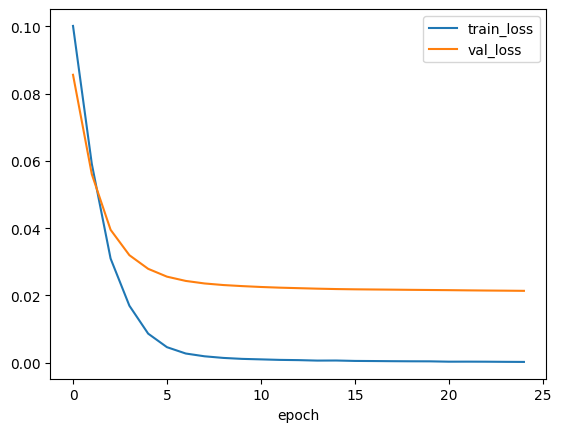

<IPython.core.display.Javascript object>

In [19]:
epoch_loss_df.plot()

### Let's examine and plot some predictions

In [20]:
X_pred, loss = model.forward(dataset.X.to(model.device), dataset.y.to(model.device))
X_pred.argmax(1).detach().cpu().numpy()

array([2, 0, 2, ..., 0, 0, 2])

<IPython.core.display.Javascript object>

In [21]:
import matplotlib.pyplot as plt
import vinplots


def _plot_label_prediction(X_pred):
    fig, axes = vinplots.quick_plot(
        nplots=1, ncols=1, figsize_width=2, figsize_height=0.5
    )
    unique_celltypes = adata.obs["louvain"].unique().tolist()

    ax = axes[0]
    ax.set_title("True / Predicted Label")

    y1 = dataset.y[0]
    y2 = X_pred[0].detach().cpu().numpy()

    x1 = np.arange(len(dataset.y[0])) - 0.1
    x2 = np.arange(len(dataset.y[0])) + 0.1

    axes[0].bar(x1, y1, alpha=1, width=0.2, color="dodgerblue", edgecolor="k")
    axes[0].bar(x2, y2, alpha=1, width=0.2, color="crimson", edgecolor="k")

    xtl = axes[0].set_xticks(range(len(unique_celltypes)), unique_celltypes)

<IPython.core.display.Javascript object>

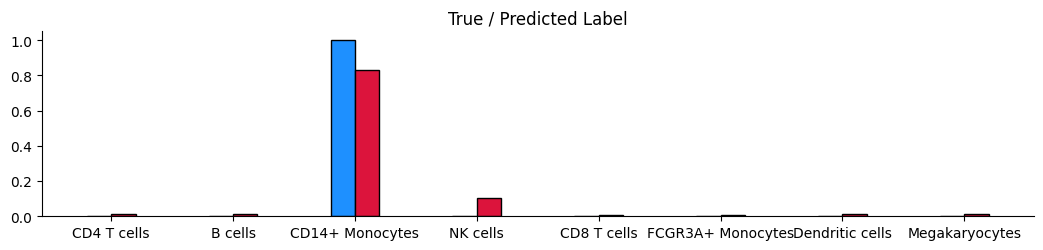

<IPython.core.display.Javascript object>

In [22]:
_plot_label_prediction(X_pred)

In [23]:
pred_labels = dataset._OneHot.inverse_transform(X_pred.detach().cpu().numpy())
adata.obs["pred_labels"] = pred_labels

df = pd.DataFrame(
    [adata.obs["louvain"].value_counts(), adata.obs["pred_labels"].value_counts()]
).T
df

,louvain,pred_labels
CD4 T cells,1144,1147
CD14+ Monocytes,480,507
B cells,342,349
CD8 T cells,316,290
NK cells,154,169
FCGR3A+ Monocytes,150,142
Dendritic cells,37,32
Megakaryocytes,15,2


<IPython.core.display.Javascript object>

In [24]:
def _build_umap_plots():

    fig, axes = vinplots.quick_plot(nplots=2, ncols=2, wspace=0.1, rm_ticks=True)
    fig.modify_spines(ax="all", spines_to_delete=["bottom", "left"])

    titles = ["True labels", "Predicted Labels"]

    for n, ax in enumerate(axes):
        ax.set_title(titles[n])
        ax.set_xlabel("UMAP-1")
        ax.set_ylabel("UMAP-2")

    return fig, axes


def _plot_prediction_umaps():

    fig, axes = _build_umap_plots()

    for group, group_df in adata.obs.groupby("louvain"):
        xu = adata[group_df.index].obsm["X_umap"]
        axes[0].scatter(
            xu[:, 0],
            xu[:, 1],
            label=group,
            color=vinplots.colors.pbmc3k[group],
            alpha=0.65,
        )
    for group, group_df in adata.obs.groupby("pred_labels"):
        xu = adata[group_df.index].obsm["X_umap"]
        axes[1].scatter(
            xu[:, 0],
            xu[:, 1],
            label=group,
            color=vinplots.colors.pbmc3k[group],
            alpha=0.65,
        )
    axes[1].legend(loc=(1, 0.45), edgecolor="w")

<IPython.core.display.Javascript object>

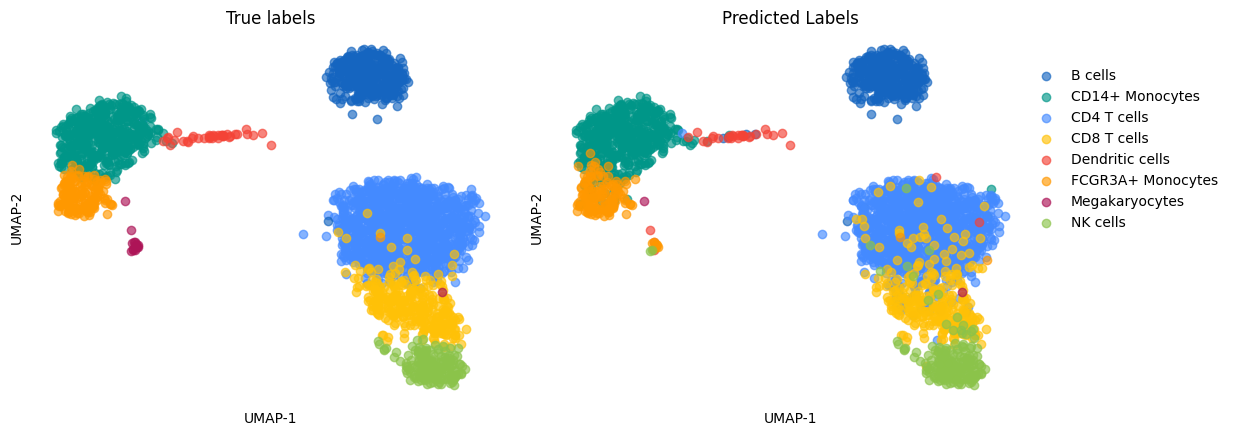

<IPython.core.display.Javascript object>

In [25]:
_plot_prediction_umaps()